## Amazon Fine Food Reviews Sentiment Analysis and Review Sentiment Prediction

#### Objective: 
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).
    
#### [Q] How to determine if a review is positive or negative?
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

To check any product details follow below step
1. open the url : https://www.amazon.com/dp/
2. pass the product id : https://www.amazon.com/dp/B00004CI84

In [55]:
# importing required libraries
import time
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

import re

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import string
from autocorrect import Speller
from textblob import TextBlob

from tqdm import tqdm

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
# using the SQLite Table to read the data
con = sqlite3.connect('C:/DevelopmentPlayground/Datasets/AmazonFoodReviewDataset/database.sqlite')

start_time = time.time()

raw_data = pd.read_sql_query(""" Select * from Reviews """, con)

print("Time took to load data :", time.time() - start_time)

Time took to load data : 8.46283769607544


## Data Cleaning

In [3]:
# checking the number of records

raw_data.shape

(568454, 10)

In [4]:
# checking top 5 records

raw_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# checking duplicate records

duplicate = raw_data[raw_data.duplicated(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])]\
.sort_values(by=['ProfileName'])

duplicate.shape

(281, 10)

In [6]:
duplicate.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
80331,80332,B000LRO5O4,ADLVFFE4VBT8,"A. Dent ""Aragorn""",0,0,5,1222992000,Say goodbye to sugar,I could not use any of the not-to-be-named pre...
424019,424020,B003YT0POA,A2GSNN6EH9K2HD,A. Meyer,0,0,5,1301875200,Very Tasty,These cereal bars are fantastic. All of their ...
546112,546113,B003YSV5ZY,A2GSNN6EH9K2HD,A. Meyer,0,0,5,1301875200,Very Tasty,These cereal bars are fantastic. All of their ...
522348,522349,B002498PVQ,A2YLC7T12FRDKJ,A. Smith,0,2,5,1267142400,the best cookies,To my European taste these and other Grisbi co...


#### There are 281 rows with duplicate data, which need to be dropped.

In [7]:
data = raw_data[~raw_data.isin(duplicate)].dropna()

In [8]:
# checking if HelpfulnessNumerator is greater than HelpfulnesDenominator

result = data[(data['HelpfulnessNumerator'] > data['HelpfulnessDenominator'])]

In [9]:
result

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737.0,B001EQ55RW,A2V0I904FH7ABY,Ram,3.0,2.0,4.0,1.212883e+09,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422.0,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3.0,1.0,5.0,1.224893e+09,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [10]:
# deleting the records where HelpfulnessNumerator is greater than HelpfulnesDenominator

data = data[~data.isin(result)].dropna()

In [11]:
# checking same review for mulitple products same time by same user

duplicated = data[data.duplicated(['UserId', 'ProfileName', 'Time', 'Summary', 'Text'])].sort_values(by=['ProfileName'])

duplicated.shape

(173001, 10)

In [12]:
duplicated.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
358218,358219.0,B0032CJPOK,A2JKR0W0EQ6QQM,,0.0,2.0,5.0,1.334966e+09,good formula!!,this formula can help baby happy every day<br ...
451901,451902.0,B00004CXX9,A34NBH479RB0E,"""dmab6395""",0.0,1.0,5.0,9.771840e+08,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA..."
374382,374383.0,B00004CI84,A34NBH479RB0E,"""dmab6395""",0.0,1.0,5.0,9.771840e+08,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA..."
374329,374330.0,B00004CI84,AAI57M3OXP5NK,"""gibraud""",0.0,0.0,5.0,1.025654e+09,Love This Movie!,This movie is a very odd movie but I love it b...
451849,451850.0,B00004CXX9,AAI57M3OXP5NK,"""gibraud""",0.0,0.0,5.0,1.025654e+09,Love This Movie!,This movie is a very odd movie but I love it b...


In [13]:
data = data[~data.isin(duplicated)].dropna()

data.shape

(395170, 10)

## Text Preprocessing

1. Remove the html tags 
2. Remove the URL
3. Expand the contracted words
4. Remove punctuations
5. Remove alpha-numeric
6. Remove stop-words and converting the words to lowercase
7. Implementing Lemmatizing

In [14]:
# Randomly checking few reviews

sent_0 = data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = data['Text'].values[4900]
print(sent_4900)
print("="*50)

sent_395126 = data['Text'].values[395126]
print(sent_395126)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
I have a whole box of peanut butter dog cookies and she wont touch them. She loves these and begs for them so it was a good buy. She is a little chihuhua and they are not too big for her mouth. About 20 per box.
When my daughter was an infant, she was allergic to something in my breastmilk and was put on Neocate which worked wonders for her allergic colitis.  For my son, we were therefore very careful when it came time to picking out a formula to supplement breastmilk.  His stomach does react when I have accidentally had more dairy than I can tolerate so my pediatrician recommended a lactose free formula, especially given our Asian background.  I wanted something organic, not soy, lactose free, and with as clean of a label as 

In [15]:
# remove html tags

def remove_html_tags(text_data):
    soup = BeautifulSoup(text_data, 'html.parser')
    return soup.get_text()

In [16]:
# remove URL

def remove_url(text_data):
    return re.sub(r"http\S+", "", text_data)

In [17]:
# expand contracted words

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    
    return phrase

In [18]:
# removing special characteres

def remove_special_characters(phrase, remove_number=False):
    
    phrase = re.sub("\S*\d\S*", "", phrase).strip()
    if remove_number:
        phrase = re.sub('[^A-Za-z]+', ' ', phrase)
    else:
        phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    
    return phrase
    

In [19]:
# remvoing stop words, lemmatizing and lowering the case

def text_preprocess(text_data):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    text = [
            lemmatizer.lemmatize(word.lower()) \
            for word in word_tokenize(text_data) \
            if word.lower() not in stop_words
           ]
    return " ".join(text)

In [20]:
# correcting spellings using autocorrect
spell = Speller(lang='en')

def correct_spelling(words):
    corrected_word_list = []
    corrected_sentences = ""
    
    for word in words:
        if word not in string.punctuation:
            wd_c = spell(word)
            if wd_c != word:
                print(word + " has been corrected to :", wd_c)
                corrected_sentences = corrected_sentences + " " + wd_c
                corrected_word_list.append(wd_c)   
            else:
                corrected_sentences = corrected_sentences + " " + word
                corrected_word_list.append(word)              
        else:
            corrected_sentences = corrected_sentences + " " + word
            corrected_word_list.append(word)
    
    return corrected_sentences, corrected_word_list

In [21]:
# correcting spellings using TextBlob's  correct() function

def correct_spelling_by_textblob(words):
    corrected_word_list = []
    corrected_sentences = ""
   
    for word in words:
        if word not in string.punctuation:
            wd_c = TextBlob(word).correct()
            if wd_c != word:
                print(word + " has been corrected to :", wd_c)
                corrected_sentences = corrected_sentences + " " + wd_c
                corrected_word_list.append(wd_c)   
            else:
                corrected_sentences = corrected_sentences + " " + word
                corrected_word_list.append(word)              
        else:
            corrected_sentences = corrected_sentences + " " + word
            corrected_word_list.append(word)
    
    return corrected_sentences, corrected_word_list

## Preprocessing Text Review

In [22]:
processed_reviews = []

start_time = time.time()
# tqdm is for showng the status bar
for sentence in tqdm(data['Text'].values):
    sentence = remove_html_tags(sentence)
    sentence = remove_url(sentence)
    sentence = decontracted(sentence)
    sentence = remove_special_characters(sentence)
   # sentence, _ = correct_spelling(sentence)
    sentence = text_preprocess(sentence)
    processed_reviews.append(sentence)
    
print('Total time took :', time.time() - start_time)

100%|█████████████████████████████████████████████████████████████████████████| 395170/395170 [12:55<00:00, 509.32it/s]

Total time took : 775.8897800445557


In [44]:
processed_reviews[0]

'bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better'

## Processing Summary Text

In [24]:
processed_summary = []

start_time = time.time()
# tqdm is for showng the status bar
for sentence in tqdm(data['Summary'].values):
    sentence = remove_html_tags(sentence)
    sentence = remove_url(sentence)
    sentence = decontracted(sentence)
    sentence = remove_special_characters(sentence)
   # sentence, _ = correct_spelling(sentence)
    sentence = text_preprocess(sentence)
    processed_summary.append(sentence)
    
print('Total time took :', time.time() - start_time)

100%|████████████████████████████████████████████████████████████████████████| 395170/395170 [06:20<00:00, 1038.80it/s]

Total time took : 380.41329288482666


In [43]:
processed_summary[0]

'good quality dog food'

## Exploratory Data Analysis

In [40]:
data['Processed_Reviews'] = processed_reviews
data['Processed_Summary'] = processed_summary
data.head(2)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Processed_Reviews,Processed_Summary
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,good quality dog food
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,advertised


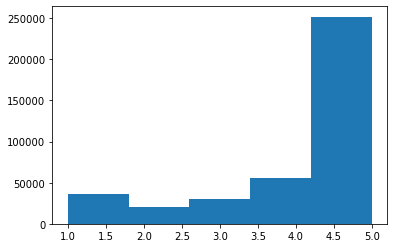

Score
1.0     36518
2.0     20846
3.0     29842
4.0     56224
5.0    251740
Name: Id, dtype: int64


In [47]:
# Checking the distrbution of the reviews based on the Score

data.Score.hist(bins=5, grid=False)
plt.show()

print(data.groupby('Score').count().Id)

#### Histograms reveals that data is highly unbalanced towards high rating.

#### To make it balanced data, sampled each score by the lowest n-count from above i.e., 20846 reviews scored as '2'

In [49]:
# creating balanced data

score_1 = data[data['Score'] == 1].sample(n=20846)
score_2 = data[data['Score'] == 2].sample(n=20846)
score_3 = data[data['Score'] == 3].sample(n=20846)
score_4 = data[data['Score'] == 4].sample(n=20846)
score_5 = data[data['Score'] == 5].sample(n=20846)

In [ ]:
# creating balanced dataset
data_reviews  = pd.concat([score_1, score_2, score_3, score_4, score_5], axis=0)

In [51]:
data_reviews.reset_index(drop=True, inplace=True)

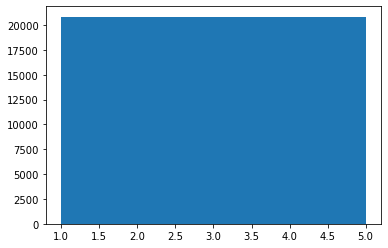

Score
1.0    20846
2.0    20846
3.0    20846
4.0    20846
5.0    20846
Name: Id, dtype: int64


In [54]:
data_reviews.Score.hist(bins=5, grid=False)
plt.show()

print(data_reviews.groupby('Score').count().Id)

## Building Word Cloud

In [56]:
# WordCloud function is used to create WordCloud on Processed_Summary

# Transforming to single string

summary_reviews_str = data_reviews.Processed_Summary.str.cat()

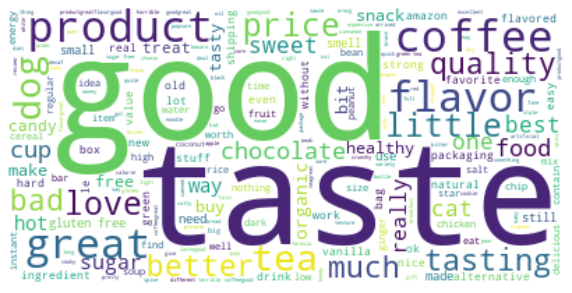

In [59]:
wordcloud = WordCloud(background_color='white').generate(summary_reviews_str)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [60]:
# Splitting the data into Negative (Score 1 or 2) and Positive (Score 4 or 5) reviews

negative_reviews = data_reviews[data_reviews['Score'].isin([1,2])]

positive_reviews = data_reviews[data_reviews['Score'].isin([4,5])]

In [61]:
# Transforming to single string

negative_reviews_str = negative_reviews.Summary.str.cat()
positive_reviews_str = positive_reviews.Summary.str.cat()

## WordCloud - Negative Reviews

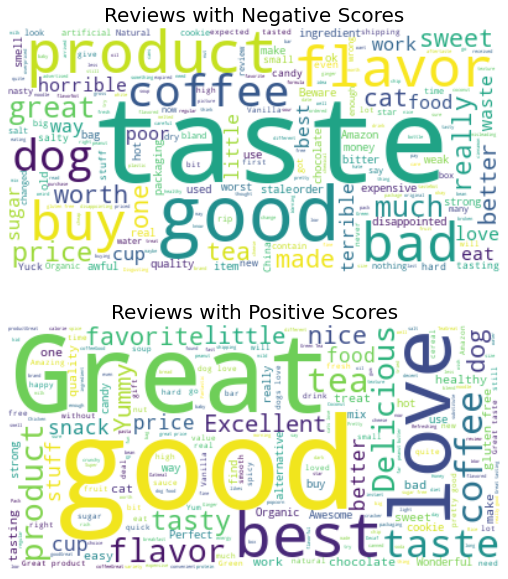

In [65]:
wordcloud_negative =WordCloud(background_color='white').generate(negative_reviews_str)
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Reviews with Negative Scores', fontsize=20)

ax2 = fig.add_subplot(212)
ax2.imshow(wordcloud_positive, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Reviews with Positive Scores', fontsize=20)

plt.show()

# Sentiment Scores

Sentiment Analysis: Pretrained model takes the input from the text
description and outputs the sentiment score ranging from -1 to +1 for each
sentence

<br/>

NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and SEntiment Reasoner).


In [66]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [67]:
# generating sentiment for all the reviews

lines = []

for row in data_reviews['Processed_Reviews']:
    sentiment = analyzer.polarity_scores(row)
    lines.append(sentiment)

In [68]:
# creating a new dataframe with sentiments

df_sentiments = pd.DataFrame(lines)
df_sentiments.head(5)

,neg,neu,pos,compound
0,0.070,0.644,0.286,0.6908
1,0.183,0.667,0.150,-0.6124
2,0.175,0.699,0.126,-0.6204
3,0.158,0.768,0.073,-0.3691
4,0.216,0.497,0.287,0.4588


In [69]:
# merging the sentiments to the reviews dataframe

final_dataset = pd.concat([data_reviews.reset_index(drop=True), df_sentiments], axis=1)
final_dataset.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Processed_Reviews,Processed_Summary,neg,neu,pos,compound
0,7075.0,B004K30HO2,A3OZLT9QX297PO,donna in texas,7.0,7.0,1.0,1.325376e+09,disposa kups ordered from Amazon,I ordered the disposa kups with the thought of...,ordered disposa kups thought making kups fit t...,disposa kups ordered amazon,0.070,0.644,0.286,0.6908
1,199899.0,B00006LL38,A2O5T0DDE5SUA8,"Reynold D. Wright ""RenHD""",0.0,0.0,1.0,1.286496e+09,Yip yap Smells like C**P,I just got a tin from the local pet store beca...,got tin local pet store pit pretty bad breath ...,yip yap smell like c p,0.183,0.667,0.150,-0.6124
2,72604.0,B004X3VRLG,A3S459EHZONQUI,pleinelune,13.0,15.0,1.0,1.308269e+09,Dog back from vet.....,Back from vet. Vet is about 100% sure it was ...,back vet vet sure chew stick upset dog digesti...,dog back vet,0.175,0.699,0.126,-0.6204


## Converting words to vectors using TFIDF Vectorizer

In [27]:
# tfidf_model = TfidfVectorizer(max_features=5000)

# tfidf_df = pd.DataFrame(tfidf_model.fit_transform(processed_reviews).todense())

In [28]:
# tfidf_df.columns = sorted(tfidf_model.vocabulary_)

In [29]:
#  tfidf_df.head(4)

## Finding optimised K-Means cluster number using elbow function 

In [30]:
# data["Reviews"] = processed_reviews

In [31]:
# data.head(2)

In [32]:
# wcss = [] # initializing the list for the values of wcss
# K = range(1, 11) # initiazling the loop value from 1 to 10

# start_time = time.time()
# for k in K: 
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_jobs=-1)
#     kmeans.fit(tfidf_df)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10,5))
# sns.lineplot(range(1, 11), wcss,marker='o',color='red')
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

# print('Total time took :', time.time() - start_time)

In [33]:
# kmeans = KMeans(n_clusters=5, n_jobs=-1)
# kmeans.fit(tfidf_df)
# y_kmeans = kmeans.predict(tfidf_df)
# data["obtained_clusters"] = y_kmeans